In [198]:
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Prep

In [199]:
df = pd.read_csv('saas.csv')
df.sort_index(ascending=True, inplace=True)

In [200]:
def prep_saas_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    df['month_invoiced'] = pd.to_datetime(df.Month_Invoiced)
    df = df.set_index('month_invoiced').sort_index()
    return df

In [201]:
df = prep_saas_data(df)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 36.2+ MB


In [203]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Id,790458.0,1.012913e+06,7591.991578,1000000.0,1006405.00,1012797.0,1019154.00,1029399.0
Invoice_Id,790458.0,5.395228e+06,228185.713880,5000000.0,5197614.25,5395228.5,5592842.75,5790457.0
Subscription_Type,790458.0,5.992349e-01,0.950380,0.0,0.00,0.0,1.00,4.0
Amount,790458.0,2.996174e+00,4.751901,0.0,0.00,0.0,5.00,20.0


In [330]:
df_resampled = df.resample('M')[['Subscription_Type', 'Amount']].sum()

In [331]:
train_size = int(round(df_resampled.shape[0]*0.5))
train_size

24

In [332]:
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

14

In [333]:
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

10

In [334]:
len(df_resampled) == train_size + validate_size + test_size

True

In [335]:
validate_end_index = train_size + validate_size
validate_end_index

38

In [336]:
train = df_resampled[:train_size]

In [337]:
train.tail()

,Subscription_Type,Amount
month_invoiced,,
2015-08-31,10099.0,50495.0
2015-09-30,10197.0,50985.0
2015-10-31,10289.0,51445.0
2015-11-30,10252.0,51260.0
2015-12-31,10301.0,51505.0


In [338]:
validate = df_resampled[train_size:validate_end_index]

In [339]:
validate.tail()

,Subscription_Type,Amount
month_invoiced,,
2016-10-31,10638.0,53190.0
2016-11-30,10675.0,53375.0
2016-12-31,10664.0,53320.0
2017-01-31,10679.0,53395.0
2017-02-28,10688.0,53440.0


In [340]:
test = df_resampled[validate_end_index:]

In [341]:
test.head()

,Subscription_Type,Amount
month_invoiced,,
2017-03-31,10696.0,53480.0
2017-04-30,10670.0,53350.0
2017-05-31,10668.0,53340.0
2017-06-30,10681.0,53405.0
2017-07-31,10736.0,53680.0


In [342]:
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [343]:
print(df_resampled.head(1) == train.head(1))

                Subscription_Type  Amount
month_invoiced                           
2014-01-31                   True    True


In [344]:
 pd.concat([test.tail(1), df_resampled.tail(1)])

,Subscription_Type,Amount
month_invoiced,,
2017-12-31,10761.0,53805.0
2017-12-31,10761.0,53805.0


In [345]:
train.columns

Index(['Subscription_Type', 'Amount'], dtype='object')

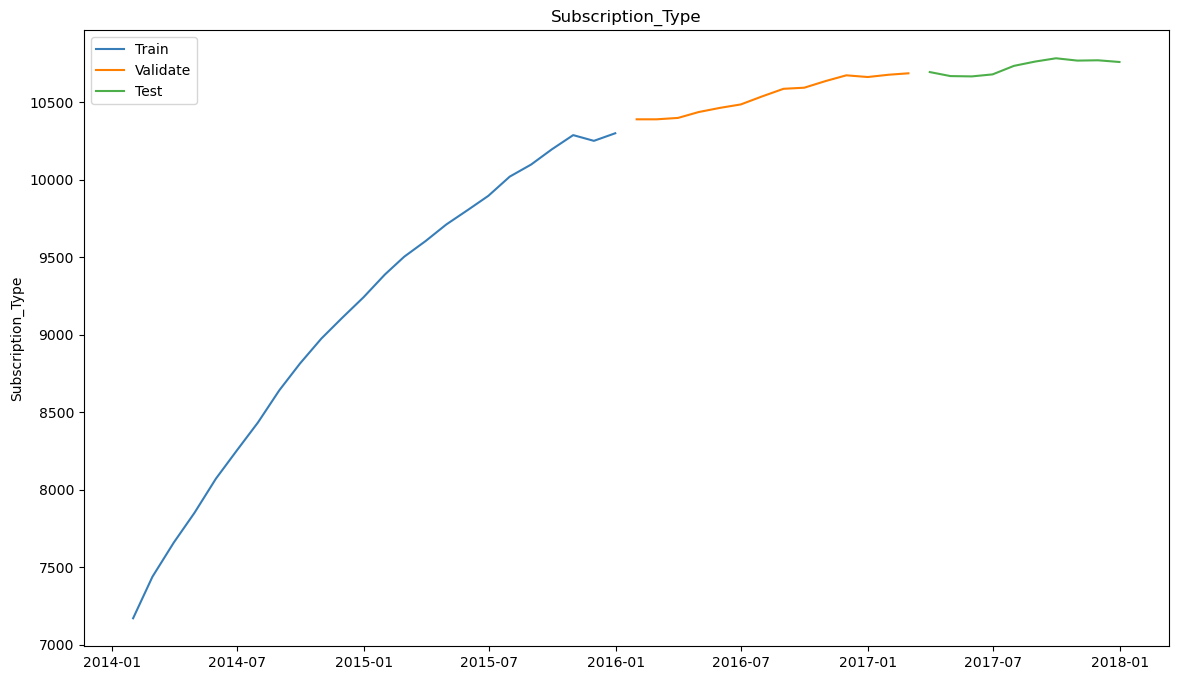

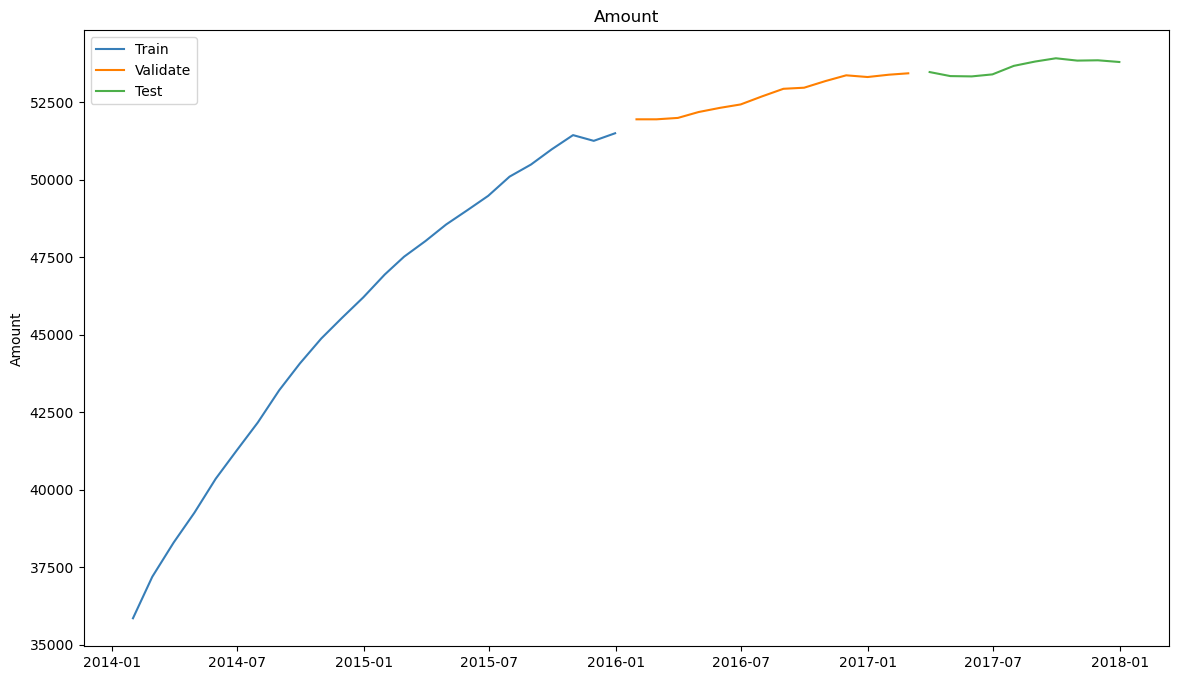

In [346]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [347]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [348]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [349]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [350]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [351]:
train['Subscription_Type'][-1:][0]

10301.0

In [352]:
last_sales = train['Subscription_Type'][-1:][0]; last_sales

10301.0

In [353]:
last_quantity = train['Amount'][-1:][0]
last_quantity

51505.0

In [354]:
yhat_df = pd.DataFrame(
    {'Subscription_Type': [last_sales],
     'Amount': [last_quantity]},
    index=validate.index)

yhat_df.head()

,Subscription_Type,Amount
month_invoiced,,
2016-01-31,10301.0,51505.0
2016-02-29,10301.0,51505.0
2016-03-31,10301.0,51505.0
2016-04-30,10301.0,51505.0
2016-05-31,10301.0,51505.0


Subscription_Type -- RMSE: 269


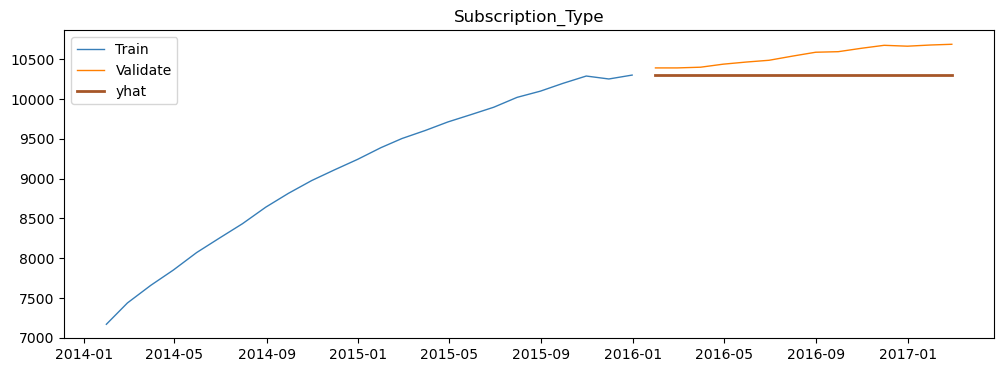

Amount -- RMSE: 1343


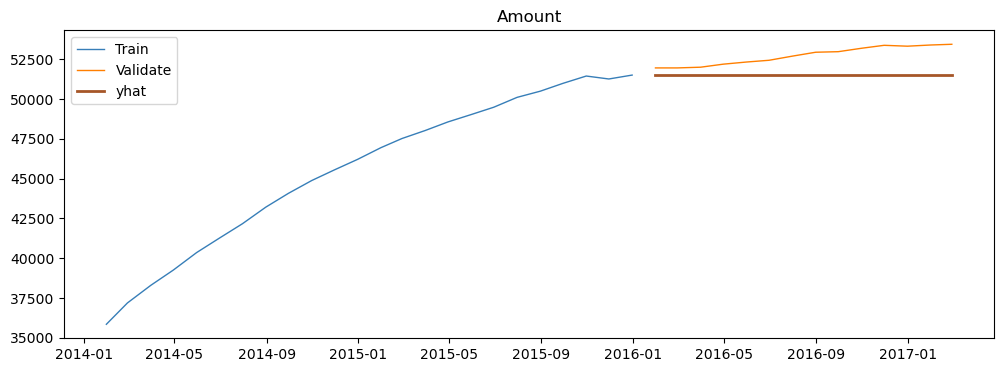

In [355]:
for col in train.columns:
    plot_and_eval(col)

In [356]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0


In [357]:
def make_baseline_predictions(sales_predictions=None, quantity_predictions=None):
    yhat_df = pd.DataFrame({'Subscription_Type': [last_sales],
                            'Amount': [last_quantity]},
                           index=validate.index)

    return yhat_df

In [358]:
period=30
train['Amount'].rolling(period).mean()

month_invoiced
2014-01-31   NaN
2014-02-28   NaN
2014-03-31   NaN
2014-04-30   NaN
2014-05-31   NaN
2014-06-30   NaN
2014-07-31   NaN
2014-08-31   NaN
2014-09-30   NaN
2014-10-31   NaN
2014-11-30   NaN
2014-12-31   NaN
2015-01-31   NaN
2015-02-28   NaN
2015-03-31   NaN
2015-04-30   NaN
2015-05-31   NaN
2015-06-30   NaN
2015-07-31   NaN
2015-08-31   NaN
2015-09-30   NaN
2015-10-31   NaN
2015-11-30   NaN
2015-12-31   NaN
Freq: M, Name: Amount, dtype: float64

In [359]:
period=30
train['Amount'].rolling(period).mean()[-1]

nan

In [360]:
rolling_sales = round(train['Subscription_Type'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['Amount'].rolling(period).mean()[-1], 2)
print(rolling_sales, rolling_quantity)

nan nan


In [361]:
yhat_df = make_baseline_predictions(rolling_sales, rolling_quantity)
yhat_df.head()

,Subscription_Type,Amount
month_invoiced,,
2016-01-31,10301.0,51505.0
2016-02-29,10301.0,51505.0
2016-03-31,10301.0,51505.0
2016-04-30,10301.0,51505.0
2016-05-31,10301.0,51505.0


In [362]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
2,30d_moving_avg,Subscription_Type,269.0
3,30d_moving_avg,Amount,1343.0


In [363]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['Subscription_Type'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['Amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_sales, rolling_quantity)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [364]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
2,30d_moving_avg,Subscription_Type,269.0
3,30d_moving_avg,Amount,1343.0
4,4_day_moving_avg,Subscription_Type,269.0
5,4_day_moving_avg,Amount,1343.0
6,12_day_moving_avg,Subscription_Type,269.0
7,12_day_moving_avg,Amount,1343.0
8,26_day_moving_avg,Subscription_Type,269.0
9,26_day_moving_avg,Amount,1343.0


In [365]:
best_quantity_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

In [366]:
best_quantity_rmse

nan

In [367]:
eval_df[eval_df.rmse == best_quantity_rmse]

,model_type,target_var,rmse


In [368]:
best_sales_total_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()

eval_df[eval_df.rmse == best_sales_total_rmse]

,model_type,target_var,rmse


In [369]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

ValueError: This function does not handle missing values

In [370]:
col = 'Amount' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [371]:
model = model.fit(optimized=True)

In [372]:
yhat_amount = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [373]:
validate.shape

(14, 2)

In [374]:
yhat_amount

2016-01-31    51748.561196
2016-02-29    51961.889989
2016-03-31    52173.186755
2016-04-30    52382.470850
2016-05-31    52589.761446
2016-06-30    52795.077530
2016-07-31    52998.437910
2016-08-31    53199.861217
2016-09-30    53399.365900
2016-10-31    53596.970235
2016-11-30    53792.692324
2016-12-31    53986.550096
2017-01-31    54178.561308
2017-02-28    54368.743551
Freq: M, dtype: float64

In [375]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

Subscription_Type -- RMSE: 103


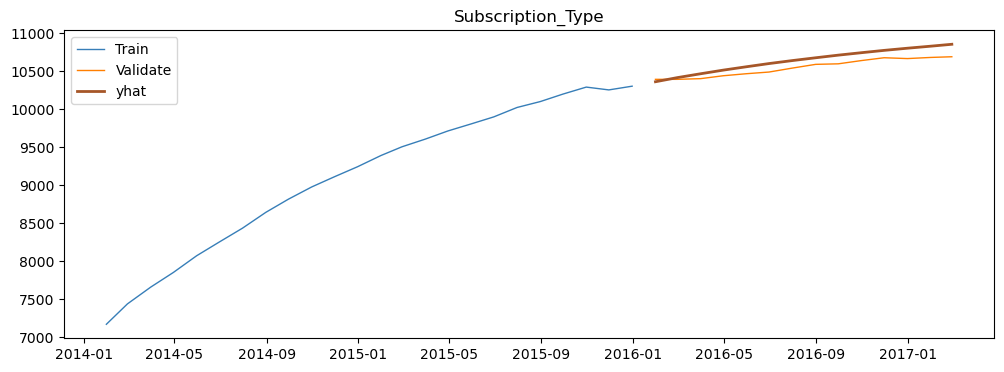

Amount -- RMSE: 456


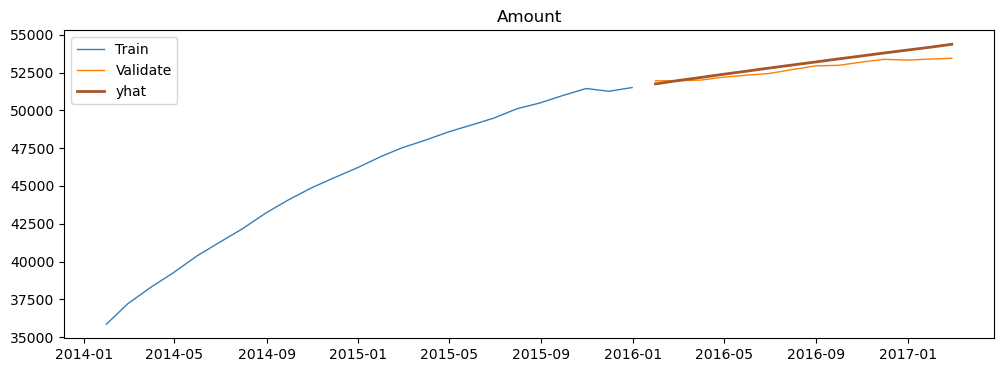

In [376]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [377]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
2,30d_moving_avg,Subscription_Type,269.0
4,4_day_moving_avg,Subscription_Type,269.0
6,12_day_moving_avg,Subscription_Type,269.0
8,26_day_moving_avg,Subscription_Type,269.0
10,52_day_moving_avg,Subscription_Type,269.0
12,104_day_moving_avg,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
3,30d_moving_avg,Amount,1343.0
5,4_day_moving_avg,Amount,1343.0


___
<center>Subscription Type</center>

|model_name|seasonal_periods|trend|seasonal|damped|
|---|---|---|---|---|
|hst_Subscription_Type_fit1|365|add|add|False|
|hst_Subscription_Type_fit2|365|add|mul|False|
|hst_Subscription_Type_fit3|365|add|add|True|
|hst_Subscription_Type_fit4|365|add|mul|True|

___
<center>Amount</center>

|model_name|seasonal_periods|trend|seasonal|damped|
|---|---|---|---|---|
|hst_Amount_fit1|365|add|add|False|
|hst_Amount_fit2|365|add|mul|False|
|hst_Amount_fit3|365|add|add|True|
|hst_Amount_fit4|365|add|mul|True|

In [382]:
# Models for quantity
hst_quantity_fit1 = ExponentialSmoothing(train.Subscription_Type, seasonal_periods=7, trend='add', seasonal='add').fit()
hst_quantity_fit2 = ExponentialSmoothing(train.Subscription_Type, seasonal_periods=7, trend='add', seasonal='mul').fit()
hst_quantity_fit3 = ExponentialSmoothing(train.Subscription_Type, seasonal_periods=7, trend='add', seasonal='add', damped=True).fit()
hst_quantity_fit4 = ExponentialSmoothing(train.Subscription_Type, seasonal_periods=7, trend='add', seasonal='mul', damped=True).fit()

# Models for sales
hst_sales_fit1 = ExponentialSmoothing(train.Amount, seasonal_periods=7, trend='add', seasonal='add').fit()
hst_sales_fit2 = ExponentialSmoothing(train.Amount, seasonal_periods=7, trend='add', seasonal='mul').fit()
hst_sales_fit3 = ExponentialSmoothing(train.Amount, seasonal_periods=7, trend='add', seasonal='add', damped=True).fit()
hst_sales_fit4 = ExponentialSmoothing(train.Amount, seasonal_periods=7, trend='add', seasonal='mul', damped=True).fit()

In [383]:
results_quantity=pd.DataFrame({'model':['hst_quantity_fit1', 'hst_quantity_fit2', 'hst_quantity_fit3', 'hst_quantity_fit4'],
                              'SSE':[hst_quantity_fit1.sse, hst_quantity_fit2.sse, hst_quantity_fit3.sse, hst_quantity_fit4.sse]})
results_quantity

,model,SSE
0,hst_quantity_fit1,23782.711091
1,hst_quantity_fit2,627361.407098
2,hst_quantity_fit3,66213.108520
3,hst_quantity_fit4,604598.118296


In [385]:
yhat_df = pd.DataFrame({'Subscription_Type': hst_sales_fit1.forecast(validate.shape[0]),
                           'Amount': hst_quantity_fit1.forecast(validate.shape[0])},
                          index=validate.index)
yhat_df

,Subscription_Type,Amount
month_invoiced,,
2016-01-31,51765.140409,10301.772416
2016-02-29,52110.951885,10340.226385
2016-03-31,52326.102976,10366.095032
2016-04-30,52526.755332,10400.380249
2016-05-31,52731.142816,10444.266903
2016-06-30,52985.785187,10455.917374
2016-07-31,53301.222588,10479.385480
2016-08-31,53536.077647,10484.860652
2016-09-30,53881.889124,10523.314621


Subscription_Type -- RMSE: 42885


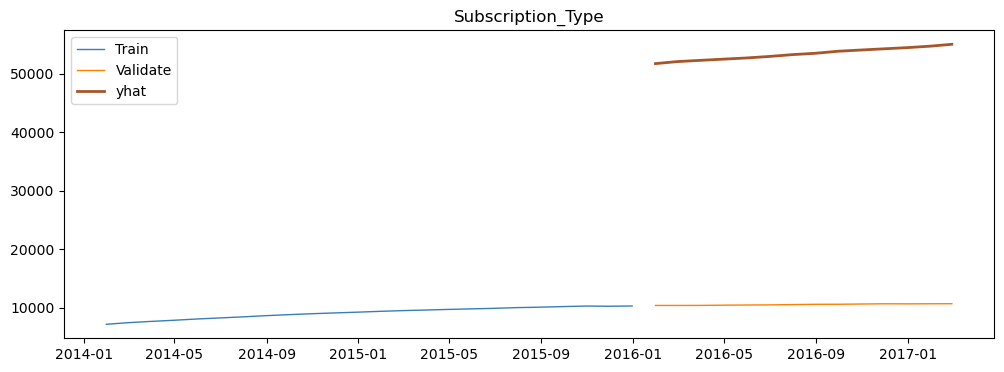

Amount -- RMSE: 42240


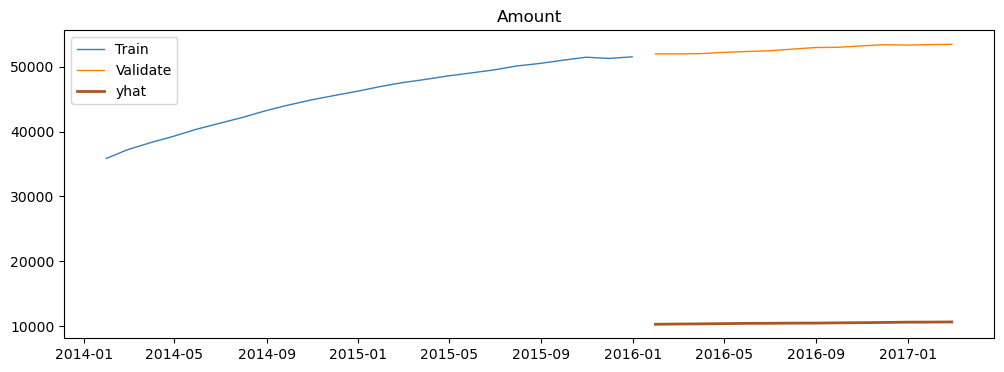

In [386]:
for col in train.columns:
    plot_and_eval(col)

In [387]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
2,30d_moving_avg,Subscription_Type,269.0
3,30d_moving_avg,Amount,1343.0
4,4_day_moving_avg,Subscription_Type,269.0
5,4_day_moving_avg,Amount,1343.0
6,12_day_moving_avg,Subscription_Type,269.0
7,12_day_moving_avg,Amount,1343.0
8,26_day_moving_avg,Subscription_Type,269.0
9,26_day_moving_avg,Amount,1343.0


In [388]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [389]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
2,30d_moving_avg,Subscription_Type,269.0
4,4_day_moving_avg,Subscription_Type,269.0
6,12_day_moving_avg,Subscription_Type,269.0
8,26_day_moving_avg,Subscription_Type,269.0
10,52_day_moving_avg,Subscription_Type,269.0
12,104_day_moving_avg,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
3,30d_moving_avg,Amount,1343.0
5,4_day_moving_avg,Amount,1343.0


In [390]:
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(24, 2)
(12, 2)
(12, 2)


,Subscription_Type,Amount
month_invoiced,,
2015-08-31,10099.0,50495.0
2015-09-30,10197.0,50985.0
2015-10-31,10289.0,51445.0
2015-11-30,10252.0,51260.0
2015-12-31,10301.0,51505.0


In [393]:
train.diff(7)

,Subscription_Type,Amount
month_invoiced,,
2014-01-31,NaN,NaN
2014-02-28,NaN,NaN
2014-03-31,NaN,NaN
2014-04-30,NaN,NaN
2014-05-31,NaN,NaN
2014-06-30,NaN,NaN
2014-07-31,NaN,NaN
2014-08-31,1472.0,7360.0
2014-09-30,1377.0,6885.0


In [394]:
yhat_df = train['2015'] + train.diff(7).mean()
yhat_df

,Subscription_Type,Amount
month_invoiced,,
2015-01-31,10340.882353,51704.411765
2015-02-28,10455.882353,52279.411765
2015-03-31,10556.882353,52784.411765
2015-04-30,10663.882353,53319.411765
2015-05-31,10756.882353,53784.411765
2015-06-30,10848.882353,54244.411765
2015-07-31,10972.882353,54864.411765
2015-08-31,11050.882353,55254.411765
2015-09-30,11148.882353,55744.411765


In [395]:
train.loc['2015'].head()

,Subscription_Type,Amount
month_invoiced,,
2015-01-31,9389.0,46945.0
2015-02-28,9504.0,47520.0
2015-03-31,9605.0,48025.0
2015-04-30,9712.0,48560.0
2015-05-31,9805.0,49025.0


In [396]:
yhat_df.head()

,Subscription_Type,Amount
month_invoiced,,
2015-01-31,10340.882353,51704.411765
2015-02-28,10455.882353,52279.411765
2015-03-31,10556.882353,52784.411765
2015-04-30,10663.882353,53319.411765
2015-05-31,10756.882353,53784.411765


In [397]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Subscription_Type,Amount
month_invoiced,,
2015-01-31,10340.882353,51704.411765
2016-01-31,10391.000000,51955.000000


In [399]:
yhat_df.index = validate.index

ValueError: Length mismatch: Expected axis has 12 elements, new values have 11 elements

In [400]:
yhat_df.shape

(12, 2)

In [401]:
validate.shape

(11, 2)

In [398]:
validate = validate[validate.index != '2016-02-29']

In [402]:
yhat_df

,Subscription_Type,Amount
month_invoiced,,
2015-01-31,10340.882353,51704.411765
2015-02-28,10455.882353,52279.411765
2015-03-31,10556.882353,52784.411765
2015-04-30,10663.882353,53319.411765
2015-05-31,10756.882353,53784.411765
2015-06-30,10848.882353,54244.411765
2015-07-31,10972.882353,54864.411765
2015-08-31,11050.882353,55254.411765
2015-09-30,11148.882353,55744.411765


In [403]:
yhat_df.index = validate.index

ValueError: Length mismatch: Expected axis has 12 elements, new values have 11 elements

In [404]:
yhat_df.head()

,Subscription_Type,Amount
month_invoiced,,
2015-01-31,10340.882353,51704.411765
2015-02-28,10455.882353,52279.411765
2015-03-31,10556.882353,52784.411765
2015-04-30,10663.882353,53319.411765
2015-05-31,10756.882353,53784.411765


In [405]:
yhat_df.describe()

,Subscription_Type,Amount
count,12.000000,12.000000
mean,10874.465686,54372.328431
std,319.331250,1596.656248
min,10340.882353,51704.411765
25%,10637.132353,53185.661765
50%,10910.882353,54554.411765
75%,11162.632353,55813.161765
max,11252.882353,56264.411765


In [406]:
yhat_df.shape

(12, 2)

ValueError: Found input variables with inconsistent numbers of samples: [11, 12]

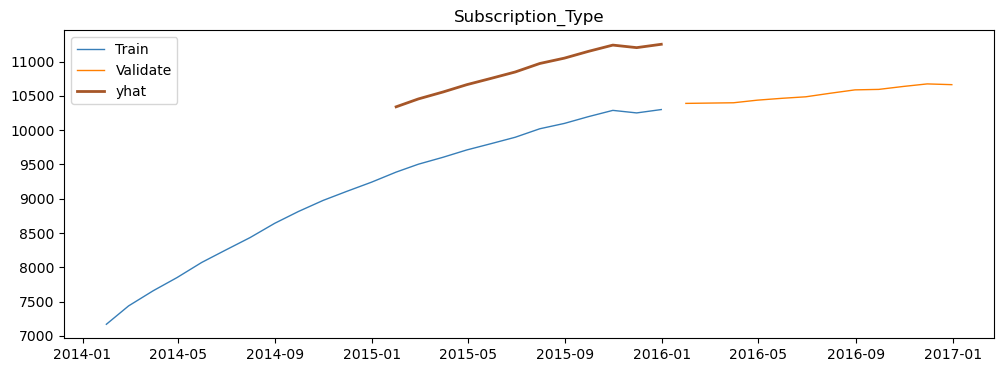

In [407]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [408]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
2,30d_moving_avg,Subscription_Type,269.0
4,4_day_moving_avg,Subscription_Type,269.0
6,12_day_moving_avg,Subscription_Type,269.0
8,26_day_moving_avg,Subscription_Type,269.0
10,52_day_moving_avg,Subscription_Type,269.0
12,104_day_moving_avg,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
3,30d_moving_avg,Amount,1343.0
5,4_day_moving_avg,Amount,1343.0


In [409]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,269.0
1,last_observed_value,Amount,1343.0
2,30d_moving_avg,Subscription_Type,269.0
3,30d_moving_avg,Amount,1343.0
4,4_day_moving_avg,Subscription_Type,269.0
5,4_day_moving_avg,Amount,1343.0
6,12_day_moving_avg,Subscription_Type,269.0
7,12_day_moving_avg,Amount,1343.0
8,26_day_moving_avg,Subscription_Type,269.0
9,26_day_moving_avg,Amount,1343.0


In [410]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [411]:
yhat_df = pd.DataFrame({'sales_total': hst_sales_fit1.forecast(validate.shape[0] + test.shape[0]),
                           'quantity': hst_quantity_fit1.forecast(validate.shape[0] + test.shape[0])})
yhat_df

,sales_total,quantity
2016-01-31,51765.140409,10301.772416
2016-02-29,52110.951885,10340.226385
2016-03-31,52326.102976,10366.095032
2016-04-30,52526.755332,10400.380249
2016-05-31,52731.142816,10444.266903
2016-06-30,52985.785187,10455.917374
2016-07-31,53301.222588,10479.385480
2016-08-31,53536.077647,10484.860652
2016-09-30,53881.889124,10523.314621
2016-10-31,54097.040215,10549.183268


In [412]:
validate.head(1)

,Subscription_Type,Amount
month_invoiced,,
2016-01-31,10391.0,51955.0


In [413]:
test.head(1)

,Subscription_Type,Amount
month_invoiced,,
2017-03-31,10696.0,53480.0


In [414]:
yhat_df = yhat_df['2017-01-01':]

In [415]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [417]:
rmse_sales_total = sqrt(mean_squared_error(test['Subscription_Type'], 
                                       yhat_df['Subscription_Type']))

rmse_quantity = sqrt(mean_squared_error(test['Amount'], 
                                       yhat_df['Amount']))

KeyError: 'Subscription_Type'